In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 3041)]               0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 64)                   1946

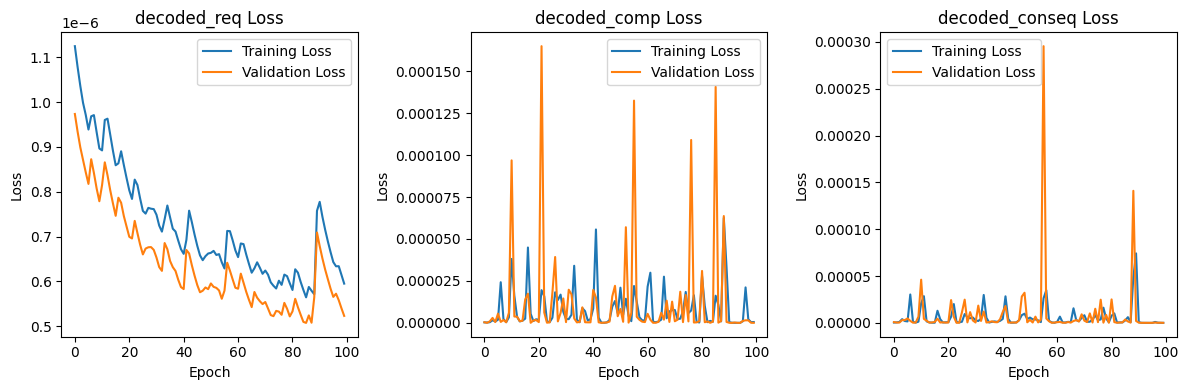

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Function to parse a string into a NumPy array
def parse_vector_string(vector_string):
    # Check if the input is a float (for cases where the vector is already a number)
    if isinstance(vector_string, float):
        return np.array([vector_string], dtype=np.float32)

    # Remove the square brackets and split the values by space
    values = vector_string.strip('[]').split()
    # Ensure that the vector has a consistent length (you can modify this condition)
    if len(values) == YOUR_VECTOR_LENGTH:
        # Convert the values to floats and create a NumPy array
        vector = np.array([float(value) for value in values], dtype=np.float32)
        return vector
    else:
        # Handle invalid vectors (e.g., return an array of zeros or NaN)
        return np.zeros(YOUR_VECTOR_LENGTH, dtype=np.float32)


from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your CSV file on Google Drive
file_path = '/content/drive/MyDrive/Final_Vectorised_Dataset.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Define the expected length of your vectors
YOUR_VECTOR_LENGTH = 3041

# Assuming the CSV file has a column 'Title_Vector' containing vector strings
requirement_vectors = data['Title_Vector'].apply(parse_vector_string)

# Filter out entries with invalid vectors
requirement_vectors = requirement_vectors[requirement_vectors.apply(lambda x: x.shape == (YOUR_VECTOR_LENGTH,))]

# Extract the relevant columns
requirement_vectors = np.array(requirement_vectors.tolist(), dtype=np.float32)
scaler = MinMaxScaler()
requirement_vectors = scaler.fit_transform(requirement_vectors)

complexity = data[['Lines of Code', 'Cyclomatic Complexity']].values
consequence = data[['Number of Calls', 'TBF', 'Reliability']].values

# Normalize the numeric data (complexity and consequence)
complexity = scaler.fit_transform(complexity)
consequence = scaler.fit_transform(consequence)

# Split the data into training and testing sets for each task
req_train, req_test = train_test_split(requirement_vectors, test_size=0.2)
comp_train, comp_test = train_test_split(complexity, test_size=0.2)
conseq_train, conseq_test = train_test_split(consequence, test_size=0.2)

# Build the autoencoder
input_layer_req = Input(shape=(YOUR_VECTOR_LENGTH,))
input_layer_comp = Input(shape=(2,))
input_layer_conseq = Input(shape=(3,))

# Encoder
encoded = Dense(64, activation='relu')(input_layer_req)
encoded_comp = Dense(32, activation='relu')(input_layer_comp)
encoded_conseq = Dense(32, activation='relu')(input_layer_conseq)

# Concatenate the encoded representations
merged = Concatenate()([encoded, encoded_comp, encoded_conseq])

# Decoder
decoded = Dense(64, activation='relu')(merged)
decoded_req = Dense(YOUR_VECTOR_LENGTH, activation='sigmoid', name='decoded_req')(decoded)
decoded_comp = Dense(2, activation='linear', name='decoded_comp')(decoded)
decoded_conseq = Dense(3, activation='linear', name='decoded_conseq')(decoded)

# Autoencoder Model
autoencoder = Model(inputs=[input_layer_req, input_layer_comp, input_layer_conseq],
                    outputs=[decoded_req, decoded_comp, decoded_conseq])

autoencoder.compile(optimizer='adam',
                    loss={'decoded_req': 'mean_squared_error',
                          'decoded_comp': 'mean_squared_error',
                          'decoded_conseq': 'mean_squared_error'})

autoencoder.summary()

# Bijective Model
bijective_input = Input(shape=(YOUR_VECTOR_LENGTH + 2 + 3,))
bijective_hidden = Dense(32, activation='relu')(bijective_input)
bijective_output = Dense(2, activation='linear')(bijective_hidden)

bijective_model = Model(inputs=bijective_input, outputs=bijective_output)

bijective_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(
    [req_train, comp_train, conseq_train],
    [req_train, comp_train, conseq_train],
    epochs=100, batch_size=32,
    validation_data=(
        [req_test, comp_test, conseq_test],
        [req_test, comp_test, conseq_test]
    )
)
import matplotlib.pyplot as plt

# ... (your existing code)

# Train the autoencoder
history = autoencoder.fit(
    [req_train, comp_train, conseq_train],
    [req_train, comp_train, conseq_train],
    epochs=100, batch_size=32,
    validation_data=(
        [req_test, comp_test, conseq_test],
        [req_test, comp_test, conseq_test]
    )
)

# Extract training and validation loss values
train_loss = history.history['decoded_req_loss']
train_loss_comp = history.history['decoded_comp_loss']
train_loss_conseq = history.history['decoded_conseq_loss']

val_loss = history.history['val_decoded_req_loss']
val_loss_comp = history.history['val_decoded_comp_loss']
val_loss_conseq = history.history['val_decoded_conseq_loss']

# Plot training and validation loss for decoded_req
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('decoded_req Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation loss for decoded_comp
plt.subplot(1, 3, 2)
plt.plot(train_loss_comp, label='Training Loss')
plt.plot(val_loss_comp, label='Validation Loss')
plt.title('decoded_comp Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation loss for decoded_conseq
plt.subplot(1, 3, 3)
plt.plot(train_loss_conseq, label='Training Loss')
plt.plot(val_loss_conseq, label='Validation Loss')
plt.title('decoded_conseq Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Train the bijective model
#bijective_input_train = np.concatenate([req_train, comp_train, conseq_train], axis=1)
#bijective_input_test = np.concatenate([req_test, comp_test, conseq_test], axis=1)

#bijective_model.fit(bijective_input_train, comp_train,
                    #epochs=100, batch_size=32,
                    #validation_data=(bijective_input_test, comp_test))


Epoch 1/100
76/76 [==============================] - 5s 26ms/step - loss: 0.0542 - val_loss: 0.0675
Epoch 2/100
76/76 [==============================] - 1s 9ms/step - loss: 0.0515 - val_loss: 0.0664
Epoch 3/100
76/76 [==============================] - 1s 7ms/step - loss: 0.0515 - val_loss: 0.0666
Epoch 4/100
76/76 [==============================] - 1s 7ms/step - loss: 0.0513 - val_loss: 0.0670
Epoch 5/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0514 - val_loss: 0.0676
Epoch 6/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.0663
Epoch 7/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.0666
Epoch 8/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.0664
Epoch 9/100
76/76 [==============================] - 0s 4ms/step - loss: 0.0512 - val_loss: 0.0665
Epoch 10/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.0666
Epoch 11

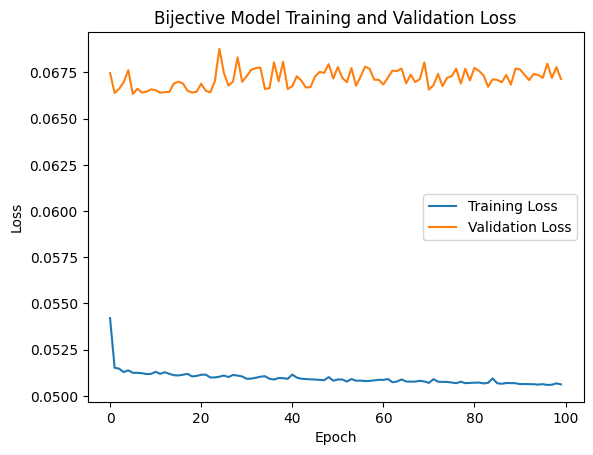

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Assuming YOUR_VECTOR_LENGTH, req_train, comp_train, conseq_train, req_test, comp_test, conseq_test are defined

# Build the bijective model
bijective_input = Input(shape=(YOUR_VECTOR_LENGTH + 2 + 3,))
bijective_hidden = Dense(32, activation='relu')(bijective_input)
bijective_output = Dense(2, activation='linear')(bijective_hidden)

bijective_model = Model(inputs=bijective_input, outputs=bijective_output)

bijective_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the bijective model
history = bijective_model.fit(
    bijective_input_train, comp_train,
    epochs=100, batch_size=32,
    validation_data=(bijective_input_test, comp_test)
)

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Bijective Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Reshape the compressed_conseq_train and compressed_conseq_test data
compressed_conseq_train = compressed_conseq_train.reshape(compressed_conseq_train.shape[0], -1)
compressed_conseq_test = compressed_conseq_test.reshape(compressed_conseq_test.shape[0], -1)

# Build the Consequences Prediction Model
conseq_prediction_input = Input(shape=(3,))  # Assuming the correct input shape
conseq_prediction_hidden = Dense(16, activation='relu')(conseq_prediction_input)
conseq_prediction_output = Dense(3, activation='linear')(conseq_prediction_hidden)

conseq_prediction_model = Model(inputs=conseq_prediction_input, outputs=conseq_prediction_output)
conseq_prediction_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Consequences prediction model
conseq_prediction_model.fit(compressed_conseq_train, conseq_train,
                            epochs=50, batch_size=32,
                            validation_data=(compressed_conseq_test, conseq_test))

NameError: ignored

NameError: ignored

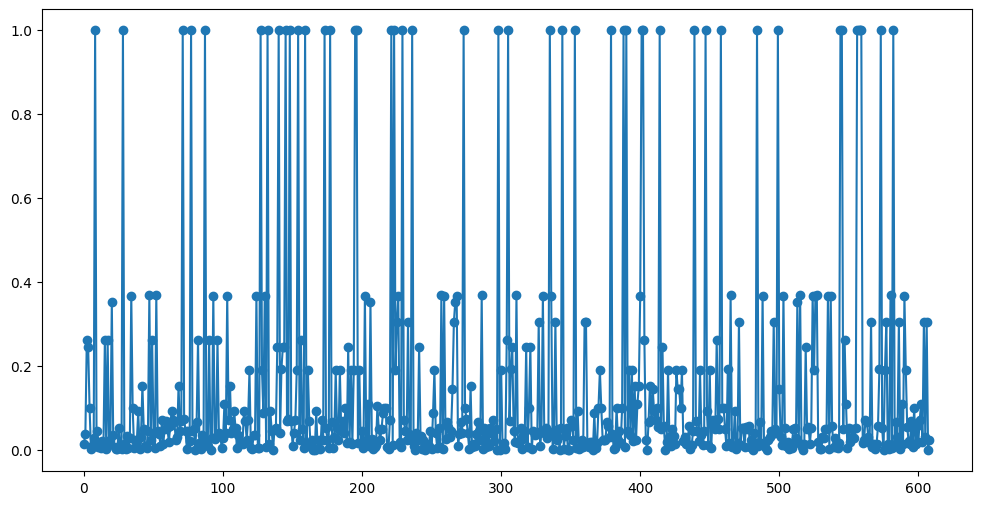

In [ ]:
import matplotlib.pyplot as plt

# Extract 'Lines of Code' and 'Cyclomatic Complexity' from the test set
actual_complexity_lines = comp_test[:, 0]
actual_complexity_cyclomatic = comp_test[:, 1]



# Create a line graph for each point
plt.figure(figsize=(12, 6))

# Line plot for 'Lines of Code'
plt.plot(np.arange(len(actual_complexity_lines)), actual_complexity_lines, marker='o', label='Actual')
plt.plot(np.arange(len(predicted_complexity_lines)), predicted_complexity_lines, marker='o', label='Predicted')

plt.xlabel('Data Point')
plt.ylabel('Lines of Code')
plt.title('Actual vs Predicted Lines of Code')
plt.legend()
plt.show()

# Line plot for 'Cyclomatic Complexity'
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(actual_complexity_cyclomatic)), actual_complexity_cyclomatic, marker='o', label='Actual')
plt.plot(np.arange(len(predicted_complexity_cyclomatic)), predicted_complexity_cyclomatic, marker='o', label='Predicted')

plt.xlabel('Data Point')
plt.ylabel('Cyclomatic Complexity')
plt.title('Actual vs Predicted Cyclomatic Complexity')
plt.legend()
plt.show()


In [ ]:
train_loss_conseq_prediction = history_conseq_prediction.history['loss']
val_loss_conseq_prediction = history_conseq_prediction.history['val_loss']

# Plot training and validation loss for the consequences prediction model
plt.plot(train_loss_conseq_prediction, label='Conseq Prediction Training Loss')
plt.plot(val_loss_conseq_prediction, label='Conseq Prediction Validation Loss')
plt.title('Consequences Prediction Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Function to parse a string into a NumPy array
def parse_vector_string(vector_string):
    # Check if the input is a float (for cases where the vector is already a number)
    if isinstance(vector_string, float):
        return np.array([vector_string], dtype=np.float32)

    # Remove the square brackets and split the values by space
    values = vector_string.strip('[]').split()
    # Ensure that the vector has a consistent length (you can modify this condition)
    if len(values) == YOUR_VECTOR_LENGTH:
        # Convert the values to floats and create a NumPy array
        vector = np.array([float(value) for value in values], dtype=np.float32)
        return vector
    else:
        # Handle invalid vectors (e.g., return an array of zeros or NaN)
        return np.zeros(YOUR_VECTOR_LENGTH, dtype=np.float32)

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your CSV file on Google Drive
file_path = '/content/drive/MyDrive/Final_Vectorised_Dataset.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Define the expected length of your vectors
YOUR_VECTOR_LENGTH = 3041  # Modify this to the actual length of your vectors

# Assuming the CSV file has a column 'Title_Vector' containing vector strings
requirement_vectors = data['Title_Vector'].apply(parse_vector_string)

# Filter out entries with invalid vectors
requirement_vectors = requirement_vectors[requirement_vectors.apply(lambda x: x.shape == (YOUR_VECTOR_LENGTH,))]

Mounted at /content/drive


In [ ]:
# Extract the relevant columns
#requirement_vectors = data['Title_Vector'].values
complexity = data[['Lines of Code', 'Cyclomatic Complexity']].values
consequence = data[['Number of Calls', 'TBF', 'Reliability']].values

In [ ]:
# Convert the filtered arrays to a NumPy array and normalize
requirement_vectors = np.array(requirement_vectors.tolist(), dtype=np.float32)
scaler = MinMaxScaler()
requirement_vectors = scaler.fit_transform(requirement_vectors)

# Normalize the numeric data (complexity and consequence)
complexity = scaler.fit_transform(complexity)
consequence = scaler.fit_transform(consequence)

In [ ]:
# Split the data into training and testing sets
req_train, req_test, comp_train, comp_test, conseq_train, conseq_test = train_test_split(
    requirement_vectors, complexity, consequence, test_size=0.2)

In [ ]:
# Build the autoencoder for the 3 main columns
input_layer = Input(shape=(YOUR_VECTOR_LENGTH,))
encoded = Dense(64, activation='relu')(input_layer)  # Adjust the layer sizes as needed
decoded = Dense(1, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
autoencoder.fit(req_train, req_train, epochs=100, batch_size=32, validation_data=(req_test, req_test))

Epoch 1/100
76/76 [==============================] - 1s 5ms/step - loss: 0.2408 - val_loss: 0.2315
Epoch 2/100
76/76 [==============================] - 0s 3ms/step - loss: 0.2228 - val_loss: 0.2141
Epoch 3/100
76/76 [==============================] - 0s 4ms/step - loss: 0.2059 - val_loss: 0.1978
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 0.1902 - val_loss: 0.1826
Epoch 5/100
76/76 [==============================] - 0s 3ms/step - loss: 0.1756 - val_loss: 0.1686
Epoch 6/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1621 - val_loss: 0.1556
Epoch 7/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1496 - val_loss: 0.1436
Epoch 8/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1381 - val_loss: 0.1326
Epoch 9/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1276 - val_loss: 0.1225
Epoch 10/100
76/76 [==============================] - 0s 3ms/step - loss: 0.1179 - val_loss: 0.1133
Epoch 11/

In [ ]:
# Calculate MSE and show as a percentage
mse = np.mean(np.square(req_test - autoencoder.predict(req_test)))
percentage_mse = mse * 100

print(f'Mean Square Error as Percentage: {percentage_mse:.2f}%')

# Calculate Mean Absolute Error (AE) for the compressed representation
ae = np.mean(np.abs(req_test - autoencoder.predict(req_test)))
percentage_ae = ae * 100

print(f'Mean Absolute Error as Percentage: {percentage_ae:.2f}%')

20/20 [==============================] - 0s 2ms/step
Mean Square Error as Percentage: 0.12%
20/20 [==============================] - 0s 2ms/step
Mean Absolute Error as Percentage: 3.53%


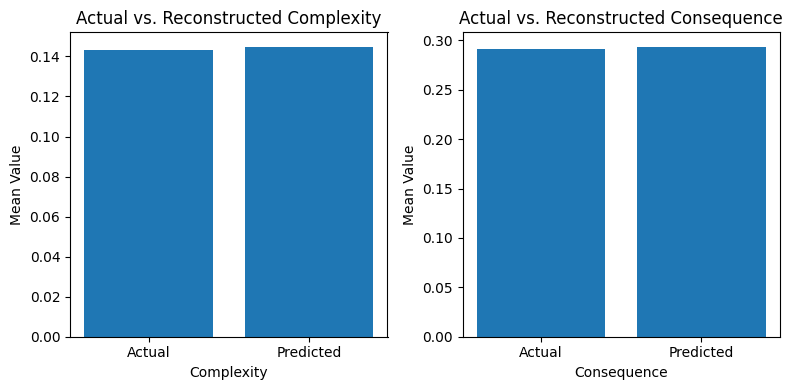

In [ ]:
# Visualize the predicted output for "time" and "cost" using bar graphs
plt.figure(figsize=(8, 4))

# Visualize "complexity" using a bar graph
plt.subplot(1, 2, 1)
plt.bar(['Actual', 'Predicted'], [np.mean(complexity), np.mean(comp_test)])
plt.xlabel("Complexity")
plt.ylabel("Mean Value")
plt.title("Actual vs. Reconstructed Complexity")

# Visualize "consequence" using a bar graph
plt.subplot(1, 2, 2)
plt.bar(['Actual', 'Predicted'], [np.mean(consequence), np.mean(conseq_test)])
plt.xlabel("Consequence")
plt.ylabel("Mean Value")
plt.title("Actual vs. Reconstructed Consequence")

plt.tight_layout()
plt.show()

In [ ]:
# Create a new model to get the compressed representation from the autoencoder
compressed_representation_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
compressed_train_data = compressed_representation_model.predict(req_train)
compressed_test_data = compressed_representation_model.predict(req_test)

# Build the bijective mapping model
bijective_input = Input(shape=(64,))  # Use the correct input shape (64 units)
bijective_output = Dense(2, activation='linear')(bijective_input)
bijective_model = Model(bijective_input, bijective_output)
bijective_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the bijective mapping model on the training data
bijective_model.fit(compressed_train_data, comp_train, epochs=100, batch_size=32, validation_data=(compressed_test_data, comp_test))

# Predict complexity values on the validation set
compressed_validation_data = compressed_representation_model.predict(req_test)  # Get compressed data
predicted_complexity = bijective_model.predict(compressed_validation_data)

20/20 [==============================] - 0s 1ms/step
Epoch 1/100
76/76 [==============================] - 1s 4ms/step - loss: 0.0659 - val_loss: 0.0639
Epoch 2/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0588
Epoch 3/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0575
Epoch 4/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0573
Epoch 5/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 6/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 7/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 8/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 9/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 10/100
76/76 [==============================] - 0s

Epoch 1/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 2/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 3/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 4/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 5/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 6/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 7/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 8/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 9/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0535 - val_loss: 0.0573
Epoch 10/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0573
Epoch 11/

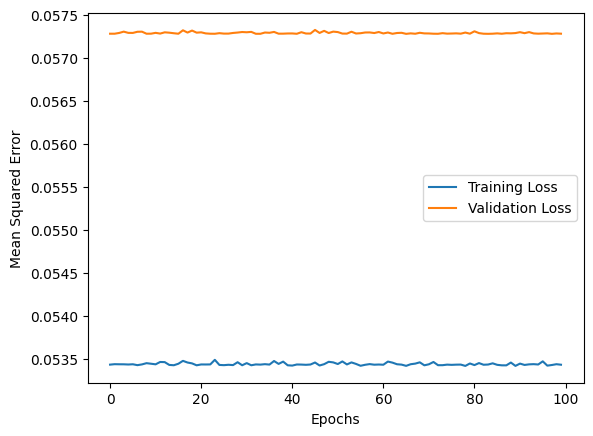

In [ ]:
history = bijective_model.fit(compressed_train_data, comp_train, epochs=100, batch_size=32, validation_data=(compressed_test_data, comp_test))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mse = mean_squared_error(comp_test, predicted_complexity)

# Calculate AE
ae = mean_absolute_error(comp_test, predicted_complexity)

# Calculate the percentage of MSE and AE relative to the range of your complexity values
range_of_complexity = np.max(comp_test) - np.min(comp_test)
percentage_mse = (mse / range_of_complexity) * 100
percentage_ae = (ae / range_of_complexity) * 100

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (AE): {ae:.2f}')
print(f'Mean Squared Error as Percentage: {percentage_mse:.2f}%')
print(f'Mean Absolute Error as Percentage: {percentage_ae:.2f}%')


Mean Squared Error (MSE): 0.05
Mean Absolute Error (AE): 0.14
Mean Squared Error as Percentage: 4.89%
Mean Absolute Error as Percentage: 14.02%


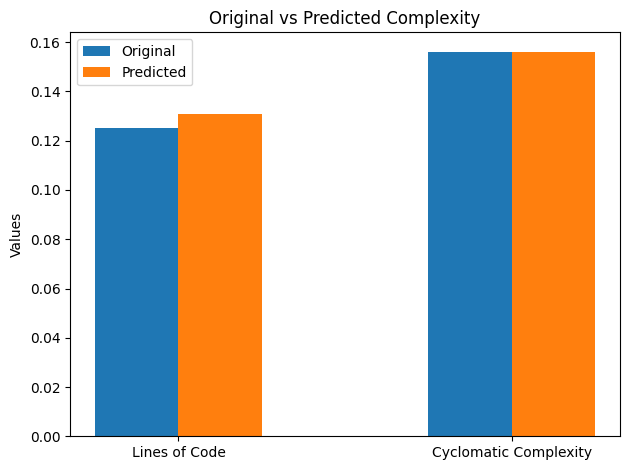

In [ ]:
import matplotlib.pyplot as plt

# Extract 'Lines of Code' and 'Cyclomatic Complexity' from the test set
lines_of_code_original = comp_test[:, 0]
cyclomatic_complexity_original = comp_test[:, 1]

# Extract the predicted values
lines_of_code_predicted = predicted_complexity[:, 0]
cyclomatic_complexity_predicted = predicted_complexity[:, 1]

# Create a bar graph
labels = ['Lines of Code', 'Cyclomatic Complexity']
original_values = [lines_of_code_original.mean(), cyclomatic_complexity_original.mean()]
predicted_values = [lines_of_code_predicted.mean(), cyclomatic_complexity_predicted.mean()]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_values, width, label='Original')
rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted')

ax.set_ylabel('Values')
ax.set_title('Original vs Predicted Complexity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Extract 'Lines of Code' and 'Cyclomatic Complexity' from the test set
lines_of_code_original = comp_test[:, 0]
cyclomatic_complexity_original = comp_test[:, 1]

# Extract the predicted values
lines_of_code_predicted = predicted_complexity[:, 0]
cyclomatic_complexity_predicted = predicted_complexity[:, 1]

# Create a bar graph
labels = ['Lines of Code', 'Cyclomatic Complexity']
original_values = [lines_of_code_original, cyclomatic_complexity_original]
predicted_values = [lines_of_code_predicted, cyclomatic_complexity_predicted()]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_values, width, label='Original')
rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted')

ax.set_ylabel('Values')
ax.set_title('Original vs Predicted Complexity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

TypeError: ignored

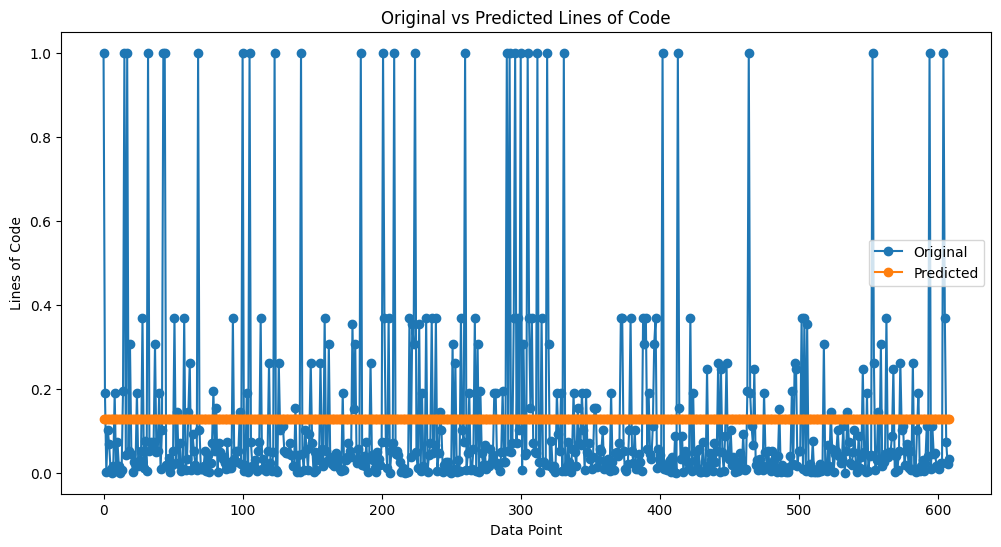

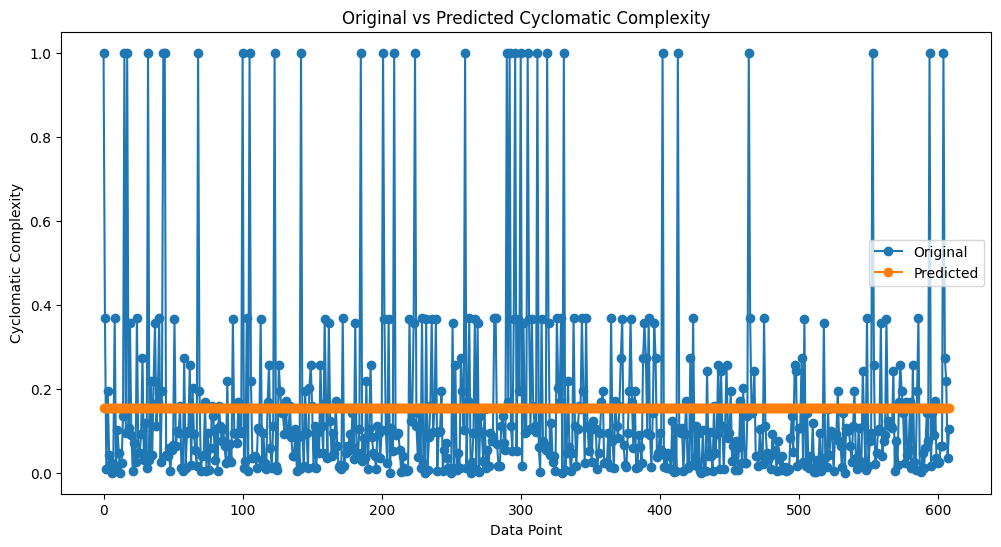

In [ ]:
import matplotlib.pyplot as plt

# Extract 'Lines of Code' and 'Cyclomatic Complexity' from the test set
lines_of_code_original = comp_test[:, 0]
cyclomatic_complexity_original = comp_test[:, 1]

# Extract the predicted values
lines_of_code_predicted = predicted_complexity[:, 0]
cyclomatic_complexity_predicted = predicted_complexity[:, 1]


# Create a line graph for each point
plt.figure(figsize=(12, 6))

# Line plot for 'Lines of Code'
plt.plot(np.arange(len(lines_of_code_original)), lines_of_code_original, marker='o', label='Original')
plt.plot(np.arange(len(lines_of_code_predicted)), lines_of_code_predicted, marker='o', label='Predicted')

plt.xlabel('Data Point')
plt.ylabel('Lines of Code')
plt.title('Original vs Predicted Lines of Code')
plt.legend()
plt.show()

# Line plot for 'Cyclomatic Complexity'
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(cyclomatic_complexity_original)), cyclomatic_complexity_original, marker='o', label='Original')
plt.plot(np.arange(len(cyclomatic_complexity_predicted)), cyclomatic_complexity_predicted, marker='o', label='Predicted')

plt.xlabel('Data Point')
plt.ylabel('Cyclomatic Complexity')
plt.title('Original vs Predicted Cyclomatic Complexity')
plt.legend()
plt.show()
plt.show()

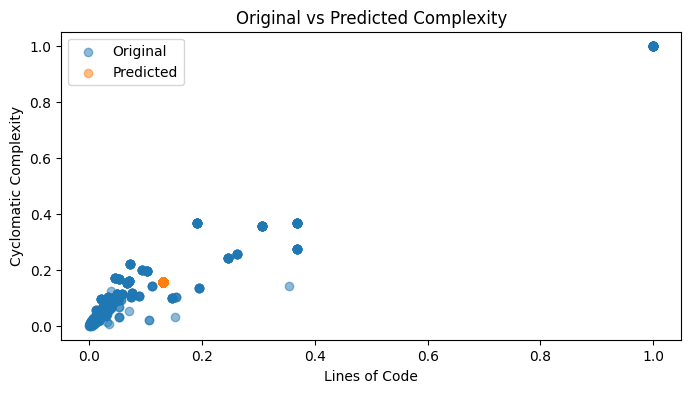

In [ ]:
# Extract 'Lines of Code' and 'Cyclomatic Complexity' from the test set
lines_of_code_original = comp_test[:, 0]
cyclomatic_complexity_original = comp_test[:, 1]

# Extract the predicted values
lines_of_code_predicted = predicted_complexity[:, 0]
cyclomatic_complexity_predicted = predicted_complexity[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 4))

plt.scatter(lines_of_code_original, cyclomatic_complexity_original, label='Original', alpha=0.5)
plt.scatter(lines_of_code_predicted, cyclomatic_complexity_predicted, label='Predicted', alpha=0.5)

plt.xlabel('Lines of Code')
plt.ylabel('Cyclomatic Complexity')
plt.title('Original vs Predicted Complexity')
plt.legend()
plt.show()


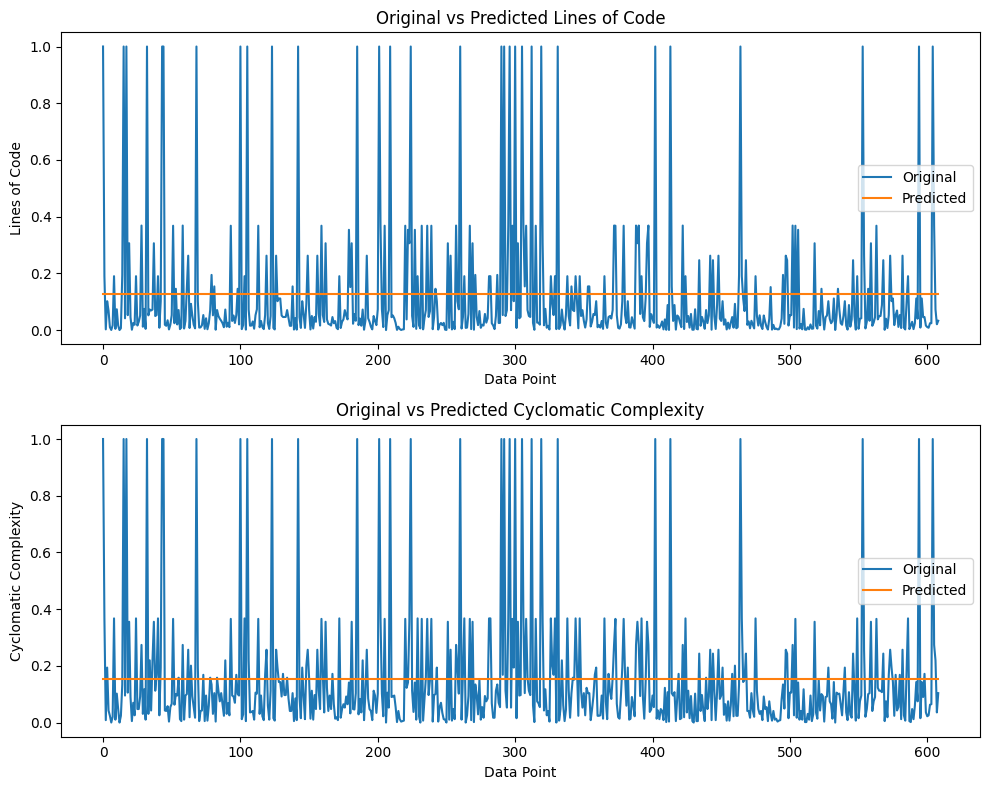

In [ ]:
import matplotlib.pyplot as plt

# Extract 'Lines of Code' and 'Cyclomatic Complexity' from the test set
lines_of_code_original = comp_test[:, 0]
cyclomatic_complexity_original = comp_test[:, 1]

# Extract the predicted values
lines_of_code_predicted = predicted_complexity[:, 0]
cyclomatic_complexity_predicted = predicted_complexity[:, 1]

# Create line graphs for individual values
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Line graph for 'Lines of Code'
ax[0].plot(lines_of_code_original, label='Original')
ax[0].plot(lines_of_code_predicted, label='Predicted')
ax[0].set_xlabel('Data Point')
ax[0].set_ylabel('Lines of Code')
ax[0].set_title('Original vs Predicted Lines of Code')
ax[0].legend()

# Line graph for 'Cyclomatic Complexity'
ax[1].plot(cyclomatic_complexity_original, label='Original')
ax[1].plot(cyclomatic_complexity_predicted, label='Predicted')
ax[1].set_xlabel('Data Point')
ax[1].set_ylabel('Cyclomatic Complexity')
ax[1].set_title('Original vs Predicted Cyclomatic Complexity')
ax[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


Epoch 1/150
76/76 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 2/150
76/76 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/150
76/76 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/150
76/76 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/150
76/76 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/150
76/76 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 9.8673e-04
Epoch 7/150
76/76 [==============================] - 0s 7ms/step - loss: 9.6835e-04 - val_loss: 9.4973e-04
Epoch 8/150
76/76 [==============================] - 0s 6ms/step - loss: 9.3207e-04 - val_loss: 9.1417e-04
Epoch 9/150
76/76 [==============================] - 0s 6ms/step - loss: 8.9719e-04 - val_loss: 8.7998e-04
Epoch 10/150
76/76 [==============================] - 1s 11ms/step - loss: 8.6

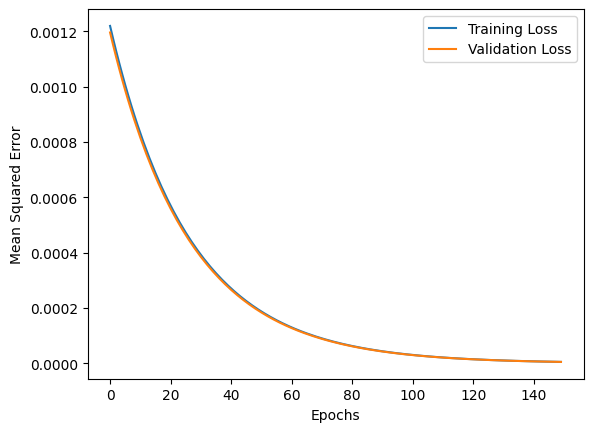

In [ ]:
history = autoencoder.fit(req_train, req_train, epochs=150, batch_size=32, validation_data=(req_test, req_test))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

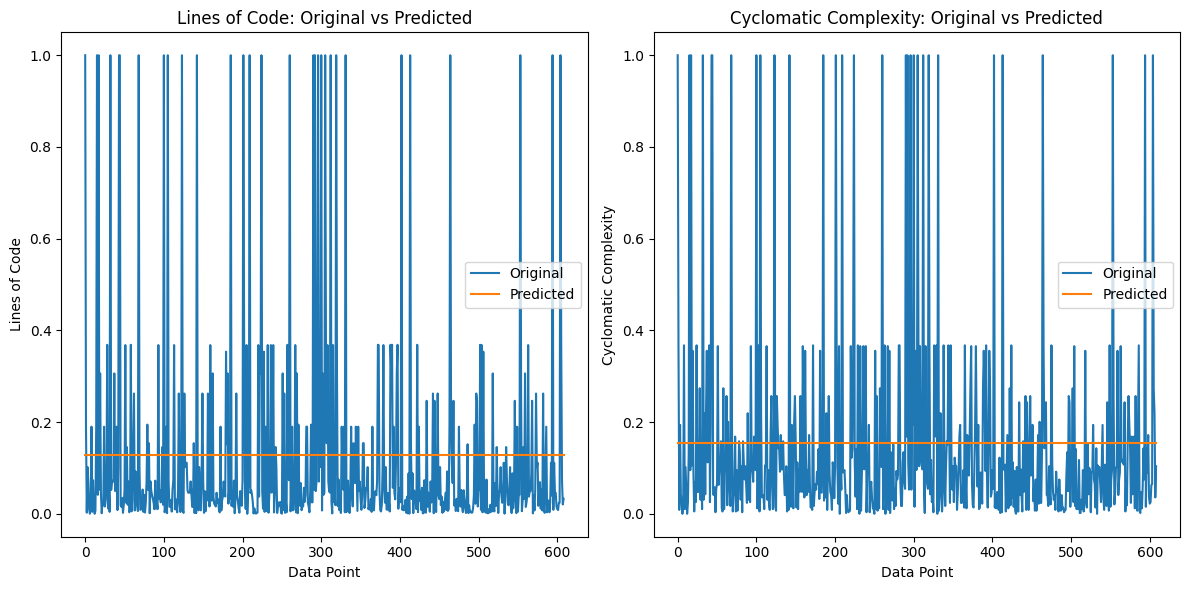

In [ ]:
import matplotlib.pyplot as plt

# Extract 'Lines of Code' and 'Cyclomatic Complexity' from the test set
lines_of_code_original = comp_test[:, 0]
cyclomatic_complexity_original = comp_test[:, 1]

# Extract the predicted values
lines_of_code_predicted = predicted_complexity[:, 0]
cyclomatic_complexity_predicted = predicted_complexity[:, 1]

# Create line graphs for 'Lines of Code'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lines_of_code_original, label='Original')
plt.plot(lines_of_code_predicted, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Lines of Code')
plt.title('Lines of Code: Original vs Predicted')
plt.legend()

# Create line graphs for 'Cyclomatic Complexity'
plt.subplot(1, 2, 2)
plt.plot(cyclomatic_complexity_original, label='Original')
plt.plot(cyclomatic_complexity_predicted, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Cyclomatic Complexity')
plt.title('Cyclomatic Complexity: Original vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()


Lines of Code - Original: [1.         0.18997599 0.00240096 0.1017407  0.06902761]
Lines of Code - Predicted: [0.12861167 0.12861167 0.12861167 0.12861167 0.12861167]
Cyclomatic Complexity - Original: [1.         0.36734694 0.0085034  0.19387755 0.04251701]
Cyclomatic Complexity - Predicted: [0.15503624 0.15503624 0.15503624 0.15503624 0.15503624]


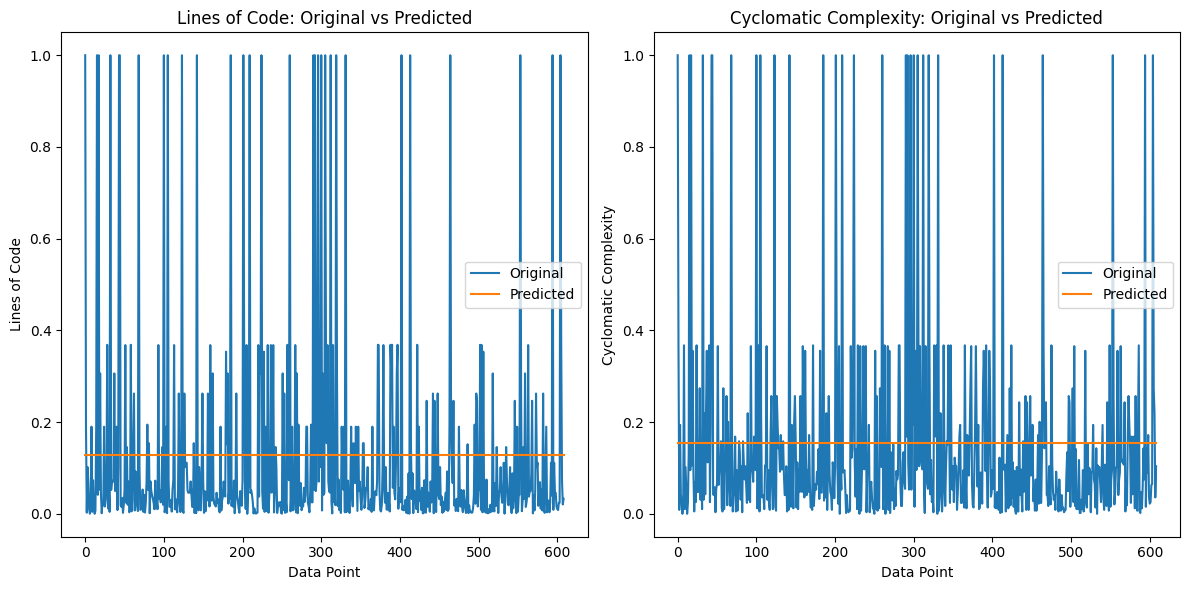

In [ ]:
# Print the first few values of original and predicted arrays
print("Lines of Code - Original:", lines_of_code_original[:5])
print("Lines of Code - Predicted:", lines_of_code_predicted[:5])

print("Cyclomatic Complexity - Original:", cyclomatic_complexity_original[:5])
print("Cyclomatic Complexity - Predicted:", cyclomatic_complexity_predicted[:5])

# Create line graphs for 'Lines of Code'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lines_of_code_original, label='Original')
plt.plot(lines_of_code_predicted, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Lines of Code')
plt.title('Lines of Code: Original vs Predicted')
plt.legend()

# Create line graphs for 'Cyclomatic Complexity'
plt.subplot(1, 2, 2)
plt.plot(cyclomatic_complexity_original, label='Original')
plt.plot(cyclomatic_complexity_predicted, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Cyclomatic Complexity')
plt.title('Cyclomatic Complexity: Original vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()
